In [1]:
import os
import sqlite3
import re
from datetime import datetime

# Caminho para o banco de dados
DB_PATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 
                     'data_warehouse', 'stellar_occultations.db')

import astro_data_access as astro_data_access

Utilizaremos o arquivo "astro_data_access.py" como nossa biblioteca pessoal para manipularmos os dados do nosso DB. Nela teremos todo o ferramental necessário para organizarmos nosso dataset!

## 1 - Primeiro passo
Interagir com a Data Base. Buscar objetos e curvas, plotá-las e analisá-las

In [2]:
astro_data_access.get_available_objects()

['1983VD7',
 '1991TF1',
 '1994XM2',
 '1998XA53',
 '1999PY3',
 '1999RU208',
 '1999TA91',
 '1999TB100',
 '1999TG246',
 '1999XR13',
 '1999XW211',
 '2000ET64',
 '2000HT75',
 '2000KJ1',
 '2000OW26',
 '2000SW106',
 '2000TK17',
 '2000WV132',
 '2001HS35',
 '2001US197',
 '2002KX14',
 '2002WC19',
 '2003GG42',
 '2003UP55',
 '2005RM43',
 '2007JJ43',
 '2014EZ51',
 'Abundantia',
 'Academia',
 'Adelheid',
 'Adelinda',
 'Admete',
 'Adorea',
 'Adria',
 'Adzhimushkaj',
 'Aegina',
 'Aegle',
 'Aeternitas',
 'Aethra',
 'Aguntina',
 'Aida',
 'Alauda',
 'Alekto',
 'Alemannia',
 'Aletheia',
 'Alfven',
 'Aline',
 'Alkmene',
 'Alphonsina',
 'Alsatia',
 'Althaea',
 'Amalia',
 'Amalthea',
 'Amata',
 'Ambrosia',
 'Anacostia',
 'Angola',
 'Ani',
 'Antenor',
 'Antigone',
 'Antilochus',
 'Antiope',
 'Antonia',
 'Arctica',
 'Arethusa',
 'Armida',
 'Artemis',
 'Asia',
 'Aspasia',
 'Asplinda',
 'Asterope',
 'Atala',
 'Atalante',
 'Ate',
 'Athamantis',
 'Aulis',
 'Aurelia',
 'Aurora',
 'Ausonia',
 'Austria',
 'Backlunda'

In [3]:
objects = astro_data_access.get_available_objects()

# Demonstração com o primeiro objeto
selected_object = objects[:2]
selected_object

['1983VD7', '1991TF1']

In [4]:
dates = [astro_data_access.get_observation_dates(object) for object in selected_object]
dates

[['2020-11-01'], ['2020-11-01']]

In [5]:
astro_data_access.search_light_curves(selected_object[0], dates[0][0])

[{'observation_id': 1,
  'observer_name': 'JordiMarco',
  'is_positive': True,
  'point_count': 1198}]

In [6]:
lcs = []
for ind_objt in range(len(selected_object)):
    for date in dates[ind_objt]:
        lcs.append(astro_data_access.search_light_curves(selected_object[ind_objt], date))
lcs

[[{'observation_id': 1,
   'observer_name': 'JordiMarco',
   'is_positive': True,
   'point_count': 1198}],
 [{'observation_id': 2,
   'observer_name': 'DHerald',
   'is_positive': True,
   'point_count': 826},
  {'observation_id': 3,
   'observer_name': 'WHanna',
   'is_positive': True,
   'point_count': 281}]]

In [7]:
lcs = [astro_data_access.search_light_curves(selected_object[ind_objt], date) 
       for ind_objt in range(len(selected_object)) 
       for date in dates[ind_objt]]
lcs

[[{'observation_id': 1,
   'observer_name': 'JordiMarco',
   'is_positive': True,
   'point_count': 1198}],
 [{'observation_id': 2,
   'observer_name': 'DHerald',
   'is_positive': True,
   'point_count': 826},
  {'observation_id': 3,
   'observer_name': 'WHanna',
   'is_positive': True,
   'point_count': 281}]]

1) buscar forma de plotar as curvas que estão sendo analisadas
2) buscar forma que recortar a parte negativa automática das curvas positivas
3) guardar essas negativas extras em um dataset a parte
4) organizar e modular o dataset final para que possa ser aplicado no script model train

In [8]:
objects = astro_data_access.get_available_objects()

# Demonstração com o primeiro objeto
selected_object = objects[:2]
print(f"\nDatas disponíveis para {selected_object}:")

dates = [astro_data_access.get_observation_dates(object) for object in selected_object]
for date in dates:
    print(f"- {date} Encontrada")

light_curves = [astro_data_access.search_light_curves(selected_object[ind_objt], date) 
       for ind_objt in range(len(selected_object)) 
       for date in dates[ind_objt]]

for list in light_curves:
    for lc in list:
        print(f"- {lc.get('observer_name')} (Positivo: {lc.get('is_positive')}, Pontos: {lc.get('point_count')})")


Datas disponíveis para ['1983VD7', '1991TF1']:
- ['2020-11-01'] Encontrada
- ['2020-11-01'] Encontrada
- JordiMarco (Positivo: True, Pontos: 1198)
- DHerald (Positivo: True, Pontos: 826)
- WHanna (Positivo: True, Pontos: 281)


In [9]:
len(astro_data_access.get_all_light_curves_from_object(object_name='Umbriel'))

18

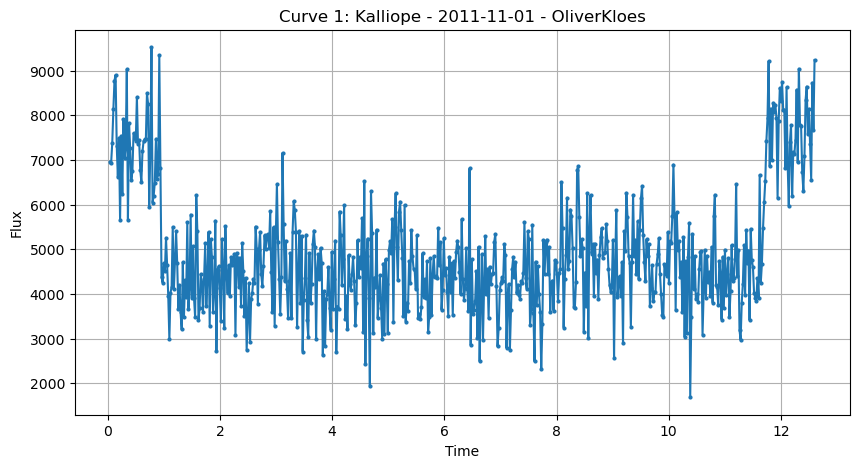

In [10]:
astro_data_access.plot_raw_curves(astro_data_access.get_all_light_curves_from_object(object_name='Kalliope'))

## 2 - Segundo passo
Ler uma amostragem grande de curvas (+100), programar um método de recortar trechos negativos e associá-los a curvas separadas negativas. 

Ideia: separar recortes em outra variável "fake_negative".

In [11]:
def recortar_negativos(curva, margem=10, threshold=0.8, min_tamanho=20, z_thresh=3):
    """
    Recorta trechos negativos (sem ocultação) de uma curva positiva, com limpeza de outliers.
    """
    import numpy as np
    import pandas as pd

    time = np.array(curva[0].get('time'))
    flux = np.array(curva[0].get('flux', 'flux_normalized'))

    # Limpeza de outliers
    time, flux = astro_data_access.remove_outliers(time, flux, z_thresh=z_thresh)

    # Identifica pontos de ocultação
    ocultando = flux < threshold
    if not np.any(ocultando):
        # Não há ocultação, retorna a curva toda como negativa
        return [pd.DataFrame({'time': time, 'flux_normalized': flux})]

    # Encontra início e fim do evento
    indices = np.where(ocultando)[0]
    inicio = indices[0]
    fim = indices[-1]

    # Trecho antes da ocultação
    antes = slice(0, max(0, inicio - margem))
    # Trecho depois da ocultação
    depois = slice(min(len(time), fim + margem), len(time))

    negativos = []
    if (antes.stop - antes.start) >= min_tamanho:
        negativos.append(pd.DataFrame({'time': time[antes], 'flux_normalized': flux[antes]}))
    if (depois.stop - depois.start) >= min_tamanho:
        negativos.append(pd.DataFrame({'time': time[depois], 'flux_normalized': flux[depois]}))

    return negativos

In [12]:
Umbriel_curves = astro_data_access.get_all_light_curves_from_object(object_name='Umbriel')

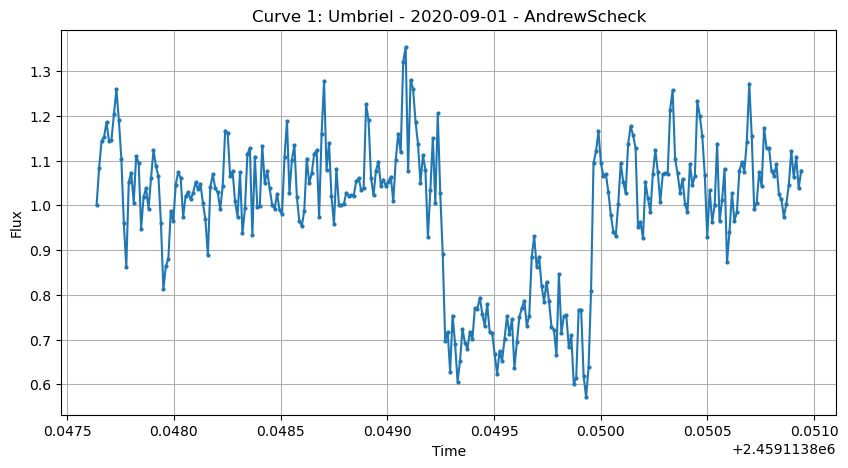

In [13]:
astro_data_access.plot_raw_curves([(Umbriel_curves[0])])

In [14]:
curve_1 = Umbriel_curves[0]
negativos = recortar_negativos(curve_1)

<Axes: xlabel='time'>

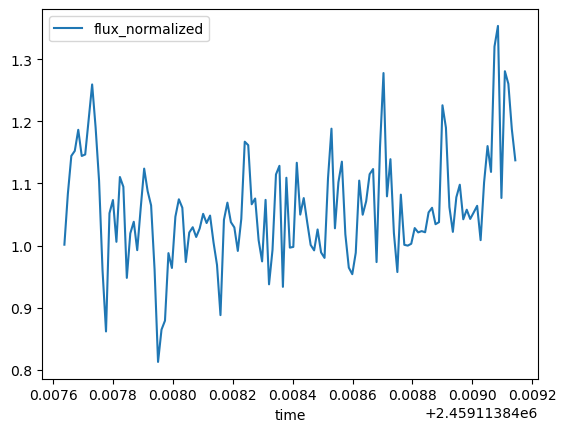

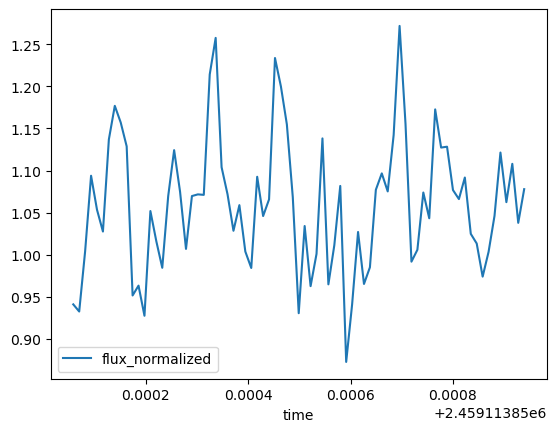

In [15]:
negativos[0].plot(x='time', y='flux_normalized')
negativos[1].plot(x='time', y='flux_normalized')

In [16]:
Umbriel_curves[-1]

({'time': [2459113.8494596,
   2459113.84947121,
   2459113.84948281,
   2459113.84949441,
   2459113.84950601,
   2459113.84951761,
   2459113.84952921,
   2459113.84955241,
   2459113.84956402,
   2459113.84957562,
   2459113.84958722,
   2459113.84959882,
   2459113.84961042,
   2459113.84962202,
   2459113.84963362,
   2459113.84964522,
   2459113.84965683,
   2459113.84966843,
   2459113.84968003,
   2459113.84969163,
   2459113.84970323,
   2459113.84971483,
   2459113.84972643,
   2459113.84973804,
   2459113.84974964,
   2459113.84976124,
   2459113.84977284,
   2459113.84978444,
   2459113.84979604,
   2459113.84980764,
   2459113.84981924,
   2459113.84983085,
   2459113.84984245,
   2459113.84985405,
   2459113.84986565,
   2459113.84987725,
   2459113.84988885,
   2459113.84990045,
   2459113.84991206,
   2459113.84992366,
   2459113.84993526,
   2459113.84994686,
   2459113.84995846,
   2459113.84997006,
   2459113.84998166,
   2459113.84999326,
   2459113.85000487,
   245

 - Comparando a curva inteira com a parte negativa recortada:

Podemos considerar essas curvas como outras negativas, para aumentar nosso dataset.

In [17]:
## guardar dataset negativo:

all_negatives_from_db = astro_data_access.get_light_curves_by_type(_type='negative', normalized=True)

In [18]:
negativos

[             time  flux_normalized
 0    2.459114e+06         1.001479
 1    2.459114e+06         1.083380
 2    2.459114e+06         1.144384
 3    2.459114e+06         1.152486
 4    2.459114e+06         1.186374
 ..            ...              ...
 126  2.459114e+06         1.076645
 127  2.459114e+06         1.280673
 128  2.459114e+06         1.260377
 129  2.459114e+06         1.187427
 130  2.459114e+06         1.137268
 
 [131 rows x 2 columns],
             time  flux_normalized
 0   2.459114e+06         0.940770
 1   2.459114e+06         0.932271
 2   2.459114e+06         1.003995
 3   2.459114e+06         1.093769
 4   2.459114e+06         1.053338
 ..           ...              ...
 72  2.459114e+06         1.121366
 73  2.459114e+06         1.062366
 74  2.459114e+06         1.107939
 75  2.459114e+06         1.037759
 76  2.459114e+06         1.077824
 
 [77 rows x 2 columns]]

In [19]:
all_curves = astro_data_access.get_all_curves()

Nenhum dado de curva de luz encontrado para esta observação


In [20]:
len(all_curves)

930

In [21]:
sampled_positives = astro_data_access.get_sampled_light_curves_by_type(_type='positive', limit=3, normalized=True)

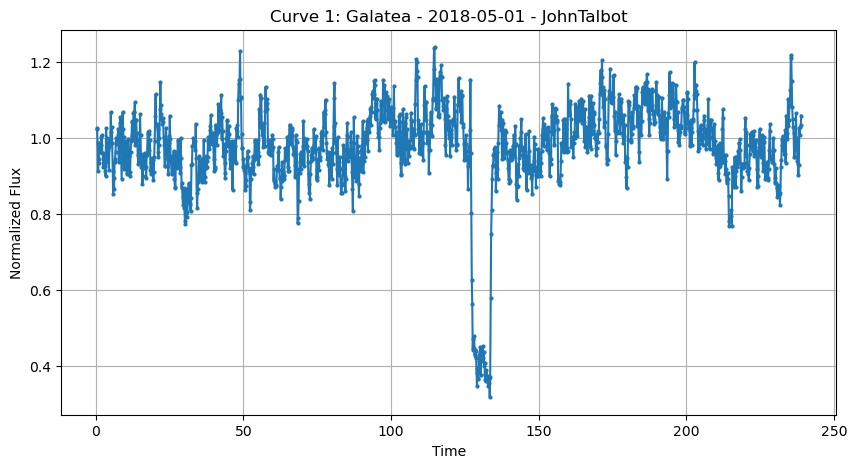

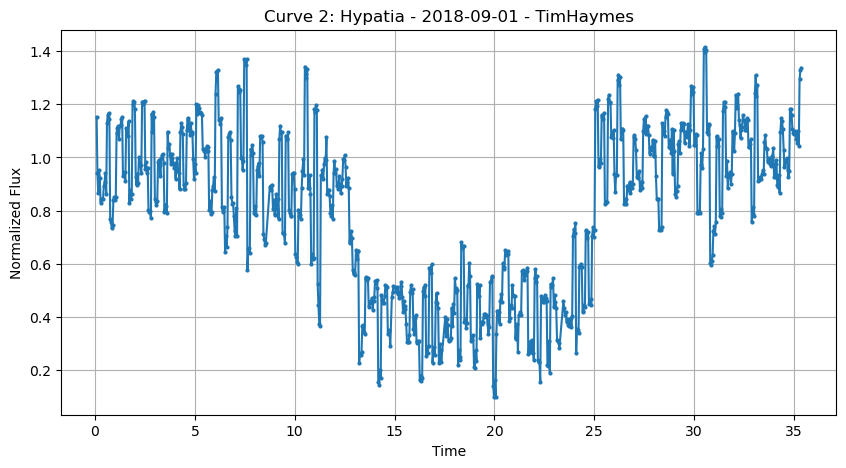

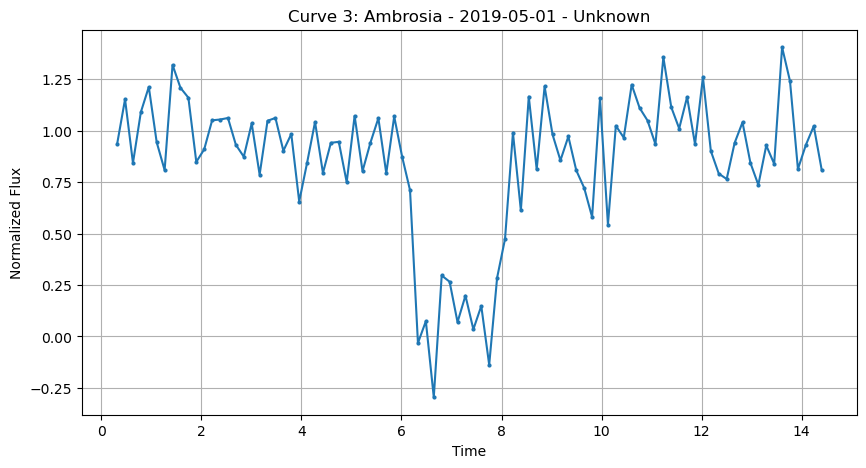

In [22]:
astro_data_access.plot_normalized_curves(sampled_positives)  

## 3 - Terceiro passo
Organizar variáveis de curvas lidas, aplicar feature engineering e criar DataSet de treino/validação.

In [23]:
def separar_curvas_especiais(amostra):
    """
    Separa curvas especiais da amostra.

    Args:
        amostra (list): Amostra de curvas de luz.
    
    Returns:
        list: List contendo as curvas especiais 
        list: List contendo as curvas não especiais.
    """

    observacoes_especiais = [('Aphonsina', '2019-10-01', 'DeanHooper'),
                            ('Hygiea', '2020-12-01', 'Unknown'),
                            ('Athamantis', '2021-01-01', 'PNosworthy'),
                            ('Polyxo', '2019-05-01', 'ChristianWeber'),
                            ('Hygiea', '2017-02-01', 'MForbes'),
                            ('Psyche', '2020-11-01', 'DHerald')]
    curvas_especiais = []
    curvas_nao_especiais = []
    for curve in amostra:
        tuple_obs = (curve[1], curve[2], curve[3])
        if tuple_obs in observacoes_especiais:
            curvas_especiais.append(curve)
        else:
            curvas_nao_especiais.append(curve)
    return curvas_especiais, curvas_nao_especiais

def fetch_all_except(exeptions: list, limit: int):
    """
    Separa curvas especiais da amostra.

    Args:
        amostra (list): Amostra de curvas de luz.
    
    Returns:
        list: List  of tuples [(object, date, observer)] 
    """
    #amostra = astro_data_access.get_first_or_last_n_curves(n = limit, first = True)
    amostra = astro_data_access.get_sampled_light_curves_by_type(_type='positive', limit=limit, normalized=True)
    curvas_especiais = []
    curvas_nao_especiais = []
    for curve in amostra:
        tuple_obs = (curve[1], curve[2], curve[3])
        if tuple_obs in exceptions:
            curvas_especiais.append(curve)
        else:
            curvas_nao_especiais.append(curve)
    return curvas_especiais, curvas_nao_especiais

Nesse caso, salvamos alguns recortes de curvas negativas 'na mão' e salvamos em 'outputs'. A ideia agora é buscarmos algumas curvas para treinar o modelo, mas recortar as observações que utilizamos para criar as curvas negativas. 

In [24]:
### Versão Simples
import pandas as pd
import os

def moving_average(df, column, window):
    # self.df['SMA_' + str(window)] = self.df['close'].rolling(window=window).mean() #criando coluna no data frame com a media movel
    df_new = df[column].rolling(window=window).mean()
    return df_new

# Pasta onde estão os CSVs
folder_path = "outputs"

# DataFrame final vazio
data_set = pd.DataFrame([])

# Itera sobre todos os arquivos .csv na pasta
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        file_path = os.path.join(folder_path, file)

        # Lê o arquivo
        data = pd.read_csv(file_path, sep=',')

        # Adiciona coluna de ocorrência (se necessário)
        data['occ'] = 0  

        if len(data) < 40:
            window = len(data)/3
        else:
            window = len(data)/40
        
        if window < 1:
            window = 2

        data['mv_av'] = moving_average(df=data, column='flux_normalized', window=int(window))


        # Calcula as features da curva
        feature_row = {
            'curve_name': file,  # Nome do arquivo para referência
            'Feature_Amp': data['flux_normalized'].max() - data['flux_normalized'].min(),
            'Feature_mv_av_Max': data['mv_av'].max(),
            'Feature_mv_av_Min': data['mv_av'].min(),
            'Feature_Flux_std': data['flux_normalized'].std(),
            'occ': 0
        }

        # Adiciona a nova linha ao data_set
        data_set = pd.concat([data_set, pd.DataFrame([feature_row])], ignore_index=True)

# Mostra o resultado final
data_set.head()

,curve_name,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_Flux_std,occ
0,Chiron_20230901_GrupoRio.csv,1.264015,1.131287,-0.000326,0.231235,0


In [25]:
import pandas as pd
import numpy as np
import os
from scipy.signal import savgol_filter
from scipy.stats import ttest_ind, ks_2samp

## Versão mais completa

def moving_average(df, column, window):
    return df[column].rolling(window=window).mean()

def max_drawdown(series):
    """ Calcula o máximo drawdown de uma série temporal """
    running_max = series.cummax()
    drawdown = (series - running_max) / running_max
    return drawdown.min()

# Pasta onde estão os CSVs
folder_path = "outputs"

# DataFrame final vazio
data_set = pd.DataFrame([])

# Itera sobre todos os arquivos .csv na pasta
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        file_path = os.path.join(folder_path, file)

        # Lê o arquivo
        data = pd.read_csv(file_path, sep=',')
        data['occ'] = 0  

        # Define janela da média móvel e filtro Savitzky-Golay
        if len(data) < 40:
            window = max(3, int(len(data)/3))
        else:
            window = max(3, int(len(data)/40))
        if window % 2 == 0:  # janela do savgol precisa ser ímpar
            window += 1

        # Média móvel
        data['mv_av'] = moving_average(data, 'flux_normalized', int(window))

        # Filtro Savitzky-Golay
        try:
            data['savgol'] = savgol_filter(data['flux_normalized'], window_length=window, polyorder=2)
        except ValueError:
            data['savgol'] = data['flux_normalized']  # fallback se janela não funcionar

        # Quartis da curva
        quartis = np.array_split(data['flux_normalized'].dropna(), 4)

        # Comparações entre quartis
        stats = {}
        comb = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
        for i,j in comb:
            if len(quartis[i]) > 1 and len(quartis[j]) > 1:
                t_stat, t_p = ttest_ind(quartis[i], quartis[j], equal_var=False)
                ks_stat, ks_p = ks_2samp(quartis[i], quartis[j])
            else:
                t_stat, t_p, ks_stat, ks_p = [np.nan]*4
            stats[f"T_{i+1}{j+1}_p"] = t_p
            stats[f"KS_{i+1}{j+1}_p"] = ks_p

        # Calcula as features da curva
        feature_row = {
            'curve_name': file,
            'Feature_Amp': data['flux_normalized'].max() - data['flux_normalized'].min(),
            'Feature_mv_av_Max': data['mv_av'].max(),
            'Feature_mv_av_Min': data['mv_av'].min(),
            'Feature_Flux_std': data['flux_normalized'].std(),
            'Feature_Savgol_Max': data['savgol'].max(),
            'Feature_Savgol_Min': data['savgol'].min(),
            'Feature_Savgol_std': np.std(data['savgol']),
            'Max_Drawdown': max_drawdown(data['flux_normalized']),
            'occ': 0
        }

        # Adiciona estatísticas dos quartis
        feature_row.update(stats)

        # Adiciona ao dataset final
        data_set = pd.concat([data_set, pd.DataFrame([feature_row])], ignore_index=True)

# Mostra o resultado final
data_set.head()

,curve_name,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_Flux_std,Feature_Savgol_Max,Feature_Savgol_Min,Feature_Savgol_std,Max_Drawdown,occ,...,T_13_p,KS_13_p,T_14_p,KS_14_p,T_23_p,KS_23_p,T_24_p,KS_24_p,T_34_p,KS_34_p
0,Chiron_20230901_GrupoRio.csv,1.264015,1.131287,-0.000326,0.231235,1.248491,-0.015524,0.230308,-1.01331,0,...,0.002745,0.000798,0.371239,0.907528,0.007182,0.14742,0.039235,0.256045,0.001992,0.001175


In [26]:
data_set.columns

Index(['curve_name', 'Feature_Amp', 'Feature_mv_av_Max', 'Feature_mv_av_Min',
       'Feature_Flux_std', 'Feature_Savgol_Max', 'Feature_Savgol_Min',
       'Feature_Savgol_std', 'Max_Drawdown', 'occ', 'T_12_p', 'KS_12_p',
       'T_13_p', 'KS_13_p', 'T_14_p', 'KS_14_p', 'T_23_p', 'KS_23_p', 'T_24_p',
       'KS_24_p', 'T_34_p', 'KS_34_p'],
      dtype='object')

## 4 - Quarto passo
Organizar o dataset final.

In [27]:
import os

# Pasta onde estão os CSVs
folder_path = "outputs"

#curvas que separei na mão
exceptions = [('Aphonsina', '2019-10-01', 'DeanHooper'), 
                            ('Hygiea', '2020-12-01', 'Unknown'),
                            ('Athamantis', '2021-01-01', 'PNosworthy'),
                            ('Polyxo', '2019-05-01', 'ChristianWeber'),
                            ('Hygiea', '2017-02-01', 'MForbes'),
                            ('Psyche', '2020-11-01', 'DHerald'),
                ('Psyche', '2020-11-01', 'DHerald')]

# Itera sobre os arquivos da pasta (adicionar à exceção as curvas que negativamos)
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        parts = file.replace(".csv", "").split("_")

        # Formato esperado: ["artific", "neg", OBSERVER, DATE, OBJECT, ...]
        if len(parts) >= 5:
            observer = parts[2]
            date = parts[3]
            obj = parts[4]
        else:
            # Se o formato não bater, preenche como Unknown
            observer, date, obj = ("Unknown", "Unknown", "Unknown")

        exceptions.append((obj, date, observer))

# Mostra a lista final
for e in exceptions:
    print(e)

exept_curves, non_exept_curves = fetch_all_except(exeptions=exceptions, limit=60)

('Aphonsina', '2019-10-01', 'DeanHooper')
('Hygiea', '2020-12-01', 'Unknown')
('Athamantis', '2021-01-01', 'PNosworthy')
('Polyxo', '2019-05-01', 'ChristianWeber')
('Hygiea', '2017-02-01', 'MForbes')
('Psyche', '2020-11-01', 'DHerald')
('Psyche', '2020-11-01', 'DHerald')
('Hekate', '2016-12-01', 'BKrobusek')
('Hekate', '2016-12-01', 'BKrobusek')
('Nausikaa', '2019-09-01', 'BobDunford')
('Capodimonte', '2020-05-01', 'DHerald')
('Irmintraud', '2016-12-01', 'EricFrappa')
('Luscinia', '2019-09-01', 'GMcKay')
('Alkmene', '2014-09-01', 'JerryBardecker')
('Gunhild', '2020-10-01', 'JerryBardecker')
('Thekla', '2020-10-01', 'JerryBardecker')
('Gunila', '2019-10-01', 'JNewman')
('Morosovia', '2020-04-01', 'MUnwin')
('Kalliope', '2011-11-01', 'OliverKloes')
('Pulcova', '2020-07-01', 'PeterTickner')
('Aspasia', '2021-01-01', 'PShottle')
('Selene', '2006-04-01', 'RobertJones')
('Bathseba', '2014-10-01', 'RobertJones')
('Galatea', '2019-11-01', 'SKerr')
('Kolga', '2020-09-01', 'SKerr')
('Kolga', '20

In [28]:
len(exept_curves)

0

In [29]:
len(non_exept_curves)

60

In [30]:
non_exept_curves[0][1]

'Leonora'

In [31]:
# Itera sobre todos os arquivos .csv na pasta
for curve in non_exept_curves:

        # Lê o arquivo
        data = pd.DataFrame(curve[0])
        data['occ'] = 1 #dessa vez só temos curvas positivas

        # Define janela da média móvel e filtro Savitzky-Golay
        if len(data) < 40:
            window = max(3, int(len(data)/3))
        else:
            window = max(3, int(len(data)/40))
        if window % 2 == 0:  # janela do savgol precisa ser ímpar
            window += 1

        # Média móvel
        data['mv_av'] = moving_average(data, 'flux_normalized', int(window))

        # Filtro Savitzky-Golay
        try:
            data['savgol'] = savgol_filter(data['flux_normalized'], window_length=window, polyorder=2)
        except ValueError:
            data['savgol'] = data['flux_normalized']  # fallback se janela não funcionar

        # Quartis da curva
        quartis = np.array_split(data['flux_normalized'].dropna(), 4)

        # Comparações entre quartis
        stats = {}
        comb = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
        for i,j in comb:
            if len(quartis[i]) > 1 and len(quartis[j]) > 1:
                t_stat, t_p = ttest_ind(quartis[i], quartis[j], equal_var=False)
                ks_stat, ks_p = ks_2samp(quartis[i], quartis[j])
            else:
                t_stat, t_p, ks_stat, ks_p = [np.nan]*4
            stats[f"T_{i+1}{j+1}_p"] = t_p
            stats[f"KS_{i+1}{j+1}_p"] = ks_p

        # Calcula as features da curva
        feature_row = {
            'curve_name': f"{curve[1]}_{curve[2]}_{curve[3]}",
            'Feature_Amp': data['flux_normalized'].max() - data['flux_normalized'].min(),
            'Feature_mv_av_Max': data['mv_av'].max(),
            'Feature_mv_av_Min': data['mv_av'].min(),
            'Feature_Flux_std': data['flux_normalized'].std(),
            'Feature_Savgol_Max': data['savgol'].max(),
            'Feature_Savgol_Min': data['savgol'].min(),
            'Feature_Savgol_std': np.std(data['savgol']),
            'Max_Drawdown': max_drawdown(data['flux_normalized']),
            'occ': 1
        }

        # Adiciona estatísticas dos quartis
        feature_row.update(stats)

        # Adiciona ao dataset final
        data_set = pd.concat([data_set, pd.DataFrame([feature_row])], ignore_index=True)

# Mostra o resultado final
data_set.tail()

c:\Users\thiag\anaconda3\envs\Trabalho\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\thiag\anaconda3\envs\Trabalho\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\thiag\anaconda3\envs\Trabalho\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\thiag\anaconda3\envs\Trabalho\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\thiag\anaconda3

,curve_name,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_Flux_std,Feature_Savgol_Max,Feature_Savgol_Min,Feature_Savgol_std,Max_Drawdown,occ,...,T_13_p,KS_13_p,T_14_p,KS_14_p,T_23_p,KS_23_p,T_24_p,KS_24_p,T_34_p,KS_34_p
90,Campania_2016-07-01_Unknown,1.697988,1.232740,0.038129,0.412072,1.473267,9.523289e-03,0.385627,-1.153634,1,...,2.496611e-15,1.254477e-12,0.290363,0.741775,2.715336e-02,0.099564,7.184328e-09,1.068401e-07,4.369172e-17,4.905820e-14
91,Notburga_2020-11-01_WHanna,1.233070,1.094221,0.326255,0.172823,1.233070,1.153637e-16,0.172125,-1.000000,1,...,3.371284e-01,1.474201e-01,0.000343,0.000400,2.210876e-02,0.147420,1.769789e-01,2.560450e-01,6.874300e-02,7.912044e-02
92,Iclea_2020-07-01_SKerr,0.965538,1.104563,0.644305,0.143659,1.143282,5.925247e-01,0.089313,-0.687388,1,...,1.154956e-01,3.943770e-01,0.250995,0.257716,9.663659e-01,0.778733,5.582684e-03,6.513725e-02,7.926811e-03,1.695403e-01
93,Hercynia_2019-12-01_PNosworthy,1.357207,1.134036,0.009393,0.335256,1.180208,-6.891293e-02,0.317201,-1.012570,1,...,1.123717e-02,3.159774e-01,0.427179,0.851701,6.448956e-07,0.000007,3.984587e-11,4.531289e-08,4.017810e-02,7.450551e-01
94,Elfriede_2015-12-01_Unknown,0.927264,1.122290,0.560507,0.189191,1.202520,5.063246e-01,0.169182,-0.712332,1,...,1.783215e-06,2.424439e-05,0.123401,0.064660,8.573810e-01,0.915126,7.675381e-08,1.005728e-05,1.318952e-08,2.140791e-06


In [32]:
data_set.describe()

,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_Flux_std,Feature_Savgol_Max,Feature_Savgol_Min,Feature_Savgol_std,Max_Drawdown,occ,T_12_p,...,T_13_p,KS_13_p,T_14_p,KS_14_p,T_23_p,KS_23_p,T_24_p,KS_24_p,T_34_p,KS_34_p
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,9.500000e+01,...,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01
mean,1.118194,1.180663,0.546320,0.233323,1.286858,0.454589,0.197107,-0.699003,0.631579,2.065531e-01,...,2.307560e-01,2.672213e-01,2.995636e-01,3.213339e-01,3.443480e-01,3.897618e-01,1.959153e-01,2.276241e-01,2.045054e-01,2.794412e-01
std,0.772129,0.135561,0.380187,0.140943,0.178720,0.385986,0.127636,0.335399,0.484935,2.865389e-01,...,3.197439e-01,3.500826e-01,3.152608e-01,3.120921e-01,3.154229e-01,3.360264e-01,2.965738e-01,3.151396e-01,3.030708e-01,3.587277e-01
min,0.232056,0.928600,-0.293009,0.034956,1.032918,-0.471151,0.018458,-1.466555,0.000000,2.337097e-80,...,4.814273e-114,2.814516e-139,5.950594e-132,5.049342e-123,8.871638e-11,6.437375e-08,3.641985e-104,2.813880e-81,6.416224e-170,4.978997e-140
25%,0.555035,1.091442,0.191754,0.135962,1.154276,0.061760,0.098263,-1.000000,0.000000,8.061226e-09,...,1.358951e-09,5.829814e-07,2.262922e-02,3.191669e-02,3.498376e-02,7.190042e-02,4.596751e-11,7.607650e-08,6.361242e-11,1.277944e-07
50%,0.927264,1.143704,0.606096,0.192467,1.239821,0.547555,0.168995,-0.635023,1.000000,1.786195e-02,...,1.321781e-02,3.813297e-02,1.719221e-01,2.252666e-01,2.700623e-01,3.517071e-01,8.619708e-03,4.427245e-02,1.219522e-02,5.046995e-02
75%,1.412900,1.236123,0.894497,0.325678,1.397217,0.817607,0.288400,-0.385783,1.000000,3.218155e-01,...,4.274291e-01,4.730750e-01,5.886514e-01,5.802162e-01,5.920241e-01,6.675102e-01,3.095121e-01,4.472997e-01,3.480463e-01,6.124535e-01
max,4.459020,1.631424,1.191566,0.786769,1.881630,0.964158,0.630934,-0.161704,1.000000,9.752754e-01,...,9.144433e-01,9.912028e-01,9.840182e-01,9.900203e-01,9.952442e-01,1.000000e+00,9.775893e-01,1.000000e+00,9.760844e-01,1.000000e+00


In [34]:
data_set['occ'].value_counts()

occ
1    60
0    35
Name: count, dtype: int64

In [35]:
data_set.to_csv("data_set.csv")

## 5 - Quinto passo
Treinar os modelos!

In [43]:
test_data_set = astro_data_access.get_all_light_curves_from_object(object_name='Umbriel')

blind_test = pd.DataFrame([])
#Nenhum elemento do dataset pertence ao Umbriel. Vamos ver se o modelo adivinha quais curvas de Umbriel são positivas e quais negativas
# Itera sobre todos os arquivos .csv na pasta
for curve in test_data_set:

        # Lê o arquivo
        data = pd.DataFrame(curve[0])
        data['flux_normalized'] = astro_data_access.normalize_flux(curve[0].get('flux'))
        #data['occ'] = 1 #dessa vez só temos curvas positivas

        # Define janela da média móvel e filtro Savitzky-Golay
        if len(data) < 40:
            window = max(3, int(len(data)/3))
        else:
            window = max(3, int(len(data)/40))
        if window % 2 == 0:  # janela do savgol precisa ser ímpar
            window += 1

        # Média móvel
        data['mv_av'] = moving_average(data, 'flux_normalized', int(window))

        # Filtro Savitzky-Golay
        try:
            data['savgol'] = savgol_filter(data['flux_normalized'], window_length=window, polyorder=2)
        except ValueError:
            data['savgol'] = data['flux_normalized']  # fallback se janela não funcionar

        # Quartis da curva
        quartis = np.array_split(data['flux_normalized'].dropna(), 4)

        # Comparações entre quartis
        stats = {}
        comb = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
        for i,j in comb:
            if len(quartis[i]) > 1 and len(quartis[j]) > 1:
                t_stat, t_p = ttest_ind(quartis[i], quartis[j], equal_var=False)
                ks_stat, ks_p = ks_2samp(quartis[i], quartis[j])
            else:
                t_stat, t_p, ks_stat, ks_p = [np.nan]*4
            stats[f"T_{i+1}{j+1}_p"] = t_p
            stats[f"KS_{i+1}{j+1}_p"] = ks_p

        # Calcula as features da curva
        feature_row = {
            'curve_name': f"{curve[1]}_{curve[2]}_{curve[3]}",
            'Feature_Amp': data['flux_normalized'].max() - data['flux_normalized'].min(),
            'Feature_mv_av_Max': data['mv_av'].max(),
            'Feature_mv_av_Min': data['mv_av'].min(),
            'Feature_Flux_std': data['flux_normalized'].std(),
            'Feature_Savgol_Max': data['savgol'].max(),
            'Feature_Savgol_Min': data['savgol'].min(),
            'Feature_Savgol_std': np.std(data['savgol']),
            'Max_Drawdown': max_drawdown(data['flux_normalized']),
           # 'occ': 1
        }

        # Adiciona estatísticas dos quartis
        feature_row.update(stats)

        # Adiciona ao dataset final
        blind_test = pd.concat([blind_test, pd.DataFrame([feature_row])], ignore_index=True)

c:\Users\thiag\anaconda3\envs\Trabalho\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\thiag\anaconda3\envs\Trabalho\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\thiag\anaconda3\envs\Trabalho\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\thiag\anaconda3\envs\Trabalho\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\thiag\anaconda3

In [45]:
blind_test.head()

,curve_name,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_Flux_std,Feature_Savgol_Max,Feature_Savgol_Min,Feature_Savgol_std,Max_Drawdown,T_12_p,...,T_13_p,KS_13_p,T_14_p,KS_14_p,T_23_p,KS_23_p,T_24_p,KS_24_p,T_34_p,KS_34_p
0,Umbriel_2020-09-01_AndrewScheck,0.736684,1.158627,0.615188,0.149593,1.186564,0.561718,0.141803,-0.578193,2.973672e-01,...,8.002989e-23,8.340473e-20,0.124502,0.276379,8.148036e-23,1.177010e-20,8.557373e-01,7.706867e-01,2.829791e-25,2.914679e-21
1,Umbriel_2020-09-01_BartonBillard,1.233945,1.132440,0.046654,0.330404,1.246496,0.012551,0.328542,-0.989931,4.192897e-05,...,2.393619e-01,7.594518e-01,0.771478,0.638574,4.675987e-04,7.289903e-03,5.055697e-05,6.738566e-04,2.888941e-01,6.323861e-01
2,Umbriel_2020-09-01_BobDunford,3.123708,1.478305,-0.353303,0.527817,1.765084,-0.689210,0.439149,-1.512430,7.892124e-02,...,1.463558e-03,1.151174e-02,0.103321,0.022355,1.306106e-06,9.909301e-05,9.714414e-01,8.645686e-01,3.233265e-06,3.240960e-05
3,Umbriel_2020-09-01_ChrisAnderson,2.045467,1.567099,0.001951,0.440340,1.673036,-0.372431,0.437646,-1.222608,7.750523e-05,...,1.106766e-02,8.214364e-03,0.838928,0.594429,1.168969e-01,2.238043e-01,6.113740e-05,1.053398e-06,8.853234e-03,1.229861e-02
4,Umbriel_2020-09-01_ChrisKitting,1.733452,1.191617,0.085538,0.447372,1.285480,0.076134,0.431510,-1.067687,5.947992e-62,...,2.386159e-61,1.550973e-48,0.001646,0.073235,2.326055e-02,3.112903e-01,3.285609e-107,5.523156e-72,1.516805e-100,3.664583e-62


 - Treinando modelo Random Forest:

In [ ]:
features = ['Feature_Amp', 'Feature_mv_av_Max', 'Feature_mv_av_Min',
       'Feature_Flux_std', 'Feature_Savgol_Max', 'Feature_Savgol_Min',
       'Feature_Savgol_std', 'Max_Drawdown','T_12_p', 'KS_12_p',
       'T_13_p', 'KS_13_p', 'T_14_p', 'KS_14_p', 'T_23_p', 'KS_23_p', 'T_24_p',
       'KS_24_p', 'T_34_p', 'KS_34_p']
target = ['occ']

data_set

Index(['curve_name', 'Feature_Amp', 'Feature_mv_av_Max', 'Feature_mv_av_Min',
       'Feature_Flux_std', 'Feature_Savgol_Max', 'Feature_Savgol_Min',
       'Feature_Savgol_std', 'Max_Drawdown', 'occ', 'T_12_p', 'KS_12_p',
       'T_13_p', 'KS_13_p', 'T_14_p', 'KS_14_p', 'T_23_p', 'KS_23_p', 'T_24_p',
       'KS_24_p', 'T_34_p', 'KS_34_p'],
      dtype='object')

In [77]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_auc_score
)

# ==========================================
# 1. SEPARANDO FEATURES E TARGET
# ==========================================
features = ['Feature_Amp', 'Feature_mv_av_Max', 'Feature_mv_av_Min',
       'Feature_Flux_std', 'Feature_Savgol_Max', 'Feature_Savgol_Min',
       'Feature_Savgol_std', 'Max_Drawdown','T_12_p', 'KS_12_p',
       'T_13_p', 'KS_13_p', 'T_14_p', 'KS_14_p', 'T_23_p', 'KS_23_p',
       'T_24_p','KS_24_p', 'T_34_p', 'KS_34_p']
target = ['occ']

X = data_set[features]
y = data_set[target].values.ravel()  # transforma em vetor 1D

# ==========================================
# 2. SEPARANDO DADOS EM TREINO/TESTE
# ==========================================
# Usamos stratify=y para respeitar o balanceamento da classe
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.45, random_state=42, stratify=y
)

# ==========================================
# 3. DEFININDO O MODELO BASE RANDOM FOREST
# ==========================================
rf = RandomForestClassifier(
    criterion="gini",   # função de impureza Gini
    random_state=42,
    n_jobs=-1           # usar todos os núcleos do processador
)

# ==========================================
# 4. GRID DE HIPERPARÂMETROS PARA TESTAR
# ==========================================
param_grid = {
    'n_estimators': [100, 300, 500],   # nº de árvores
    'max_depth': [None, 5, 10, 20],   # profundidade máxima
    'min_samples_split': [2, 5, 10],  # mínimo de amostras p/ split
    'min_samples_leaf': [1, 2, 4]     # mínimo de amostras na folha
}

# ==========================================
# 5. CROSS-VALIDATION E GRID SEARCH
# ==========================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",    # como o dataset é desbalanceado, f1 é mais informativo
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

# ==========================================
# 6. AVALIANDO O MODELO FINAL
# ==========================================
best_rf = grid_search.best_estimator_

# Predição no teste
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]  # probabilidade classe 1

# Métricas principais
print("\nResultados no conjunto de teste:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Relatório detalhado
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# ==========================================
# 7. IMPORTÂNCIA DAS FEATURES
# ==========================================
importances = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nImportância das Features:")
print(importances)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Melhores hiperparâmetros encontrados:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Resultados no conjunto de teste:
Accuracy: 0.9767441860465116
Precision: 1.0
Recall: 0.9629629629629629
F1 Score: 0.9811320754716981
ROC-AUC: 1.0

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.96      0.98        27

    accuracy                           0.98        43
   macro avg       0.97      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43


Matriz de Confusão:
[[16  0]
 [ 1 26]]

Importância das Features:
               Feature  Importance
2    Feature_mv_av_Min    0.183500
7         Max_Drawdown    0.160133
5   Feature_Savgol_Min    0.158086
10              T_13_p    0.081328
0          Feature_Amp    0.072551
11             KS_13_p    0.058

- Métricas principais

Accuracy ~ 0.977 → modelo acertou a grande maioria das instâncias do teste.

Precision = 1.0 para a classe 1 → nenhum falso positivo: todas as previsões de “1” estavam corretas.

Recall ~ 0.963 para a classe 1 → houve apenas 1 falso negativo (uma instância de classe 1 que foi classificada como 0).

F1 ~ 0.981 → ótimo equilíbrio entre precisão e recall.

ROC-AUC = 1.0 → o modelo separa perfeitamente as duas classes no teste.

✅ Isso mostra que o modelo está performando muito bem, mas ainda há pequena chance de erro (1 instância errada no teste).

- Matriz de Confusão

Classe 0: 16 corretas, 0 erradas → perfeito.

Classe 1: 26 corretas, 1 errada → um único falso negativo.

Pequena falha, mas dentro do esperado dado o tamanho do dataset (43 instâncias no teste).

- Importância das Features

Feature_mv_av_Min (~18%) → variação mínima da média móvel é mais relevante para distinguir curvas.

Max_Drawdown (~16%) → como esperado, drawdown máximo captura queda da curva, importante para classificação.

Feature_Savgol_Min (~16%) → valor mínimo após suavização também discrimina bem.

T_13_p (~8%) → p-value do teste t entre quartis 1 e 3 contribui menos, mas ainda relevante.

Feature_Amp (~7%) → amplitude da curva tem impacto menor, mas ainda relevante.

💡 O modelo está priorizando valores mínimos e variações da curva, que faz sentido no contexto de detecção de eventos em curvas de luz.

Testando modelo no teste cego (dados reais de Umbriel)

In [78]:
blind_test[features]

,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_Flux_std,Feature_Savgol_Max,Feature_Savgol_Min,Feature_Savgol_std,Max_Drawdown,T_12_p,KS_12_p,T_13_p,KS_13_p,T_14_p,KS_14_p,T_23_p,KS_23_p,T_24_p,KS_24_p,T_34_p,KS_34_p
0,0.736684,1.158627,0.615188,0.149593,1.186564,0.561718,0.141803,-0.578193,2.973672e-01,4.938319e-01,8.002989e-23,8.340473e-20,1.245022e-01,2.763790e-01,8.148036e-23,1.177010e-20,8.557373e-01,7.706867e-01,2.829791e-25,2.914679e-21
1,1.233945,1.132440,0.046654,0.330404,1.246496,0.012551,0.328542,-0.989931,4.192897e-05,4.305195e-04,2.393619e-01,7.594518e-01,7.714781e-01,6.385743e-01,4.675987e-04,7.289903e-03,5.055697e-05,6.738566e-04,2.888941e-01,6.323861e-01
2,3.123708,1.478305,-0.353303,0.527817,1.765084,-0.689210,0.439149,-1.512430,7.892124e-02,6.779471e-02,1.463558e-03,1.151174e-02,1.033205e-01,2.235514e-02,1.306106e-06,9.909301e-05,9.714414e-01,8.645686e-01,3.233265e-06,3.240960e-05
3,2.045467,1.567099,0.001951,0.440340,1.673036,-0.372431,0.437646,-1.222608,7.750523e-05,1.949172e-05,1.106766e-02,8.214364e-03,8.389278e-01,5.944294e-01,1.168969e-01,2.238043e-01,6.113740e-05,1.053398e-06,8.853234e-03,1.229861e-02
4,1.733452,1.191617,0.085538,0.447372,1.285480,0.076134,0.431510,-1.067687,5.947992e-62,8.684459e-55,2.386159e-61,1.550973e-48,1.646164e-03,7.323466e-02,2.326055e-02,3.112903e-01,3.285609e-107,5.523156e-72,1.516805e-100,3.664583e-62
5,1.672327,1.175810,0.245253,0.292662,1.268981,0.230875,0.279153,-0.906500,2.317197e-01,6.643356e-01,1.636391e-23,5.528870e-18,2.880974e-02,2.170022e-01,6.610924e-25,9.781847e-19,3.569953e-03,4.432063e-02,6.056699e-18,6.620605e-14
6,1.107739,1.063778,0.404069,0.281505,1.116992,0.382605,0.260902,-0.805459,4.319097e-79,4.363641e-80,3.591670e-77,1.283782e-78,5.584124e-01,5.513144e-01,8.344458e-01,8.014283e-01,1.348521e-77,2.379800e-79,1.102849e-75,3.616691e-77
7,2.010461,1.098314,0.215269,0.375097,1.178974,0.193330,0.357782,-0.970448,1.339782e-78,1.690540e-65,8.123506e-61,6.355845e-57,5.729862e-01,4.296287e-01,1.505051e-01,3.488142e-01,1.246877e-77,3.175125e-66,8.447974e-60,1.119532e-56
8,1.256525,1.109351,0.151651,0.332461,1.187759,0.091993,0.317438,-0.936005,1.701338e-02,2.520218e-01,9.483423e-39,6.799717e-35,3.357160e-01,3.521534e-01,1.953647e-32,1.923465e-28,1.424692e-03,1.610270e-01,4.781610e-40,2.395355e-35
9,1.526137,1.095743,0.156676,0.349671,1.125598,0.036514,0.335568,-1.157189,6.927967e-02,3.083896e-02,5.157602e-15,1.050890e-11,1.276454e-23,3.420962e-18,1.762194e-16,1.050890e-11,3.271133e-25,1.044780e-17,2.481011e-02,6.956560e-03


In [79]:
y_pred_umbriel = best_rf.predict(blind_test[features])
blind_test['predict'] = y_pred_umbriel

In [80]:
blind_test[blind_test['predict'] == 0]

,curve_name,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_Flux_std,Feature_Savgol_Max,Feature_Savgol_Min,Feature_Savgol_std,Max_Drawdown,T_12_p,...,KS_13_p,T_14_p,KS_14_p,T_23_p,KS_23_p,T_24_p,KS_24_p,T_34_p,KS_34_p,predict
13,Umbriel_2020-09-01_PeterCeravolo,0.813822,1.145733,0.871268,0.149512,1.160179,0.797528,0.064478,-0.576923,0.866736,...,0.708661,0.024676,0.617405,0.175900,0.795314,0.016709,0.367556,0.322286,0.932944,0
17,Umbriel_2020-09-01_WilliamHanna,0.405463,1.040256,0.940961,0.058563,1.118835,0.915079,0.032356,-0.315126,0.342230,...,0.388282,0.737675,0.945484,0.616091,0.623669,0.214597,0.388282,0.105530,0.216108,0


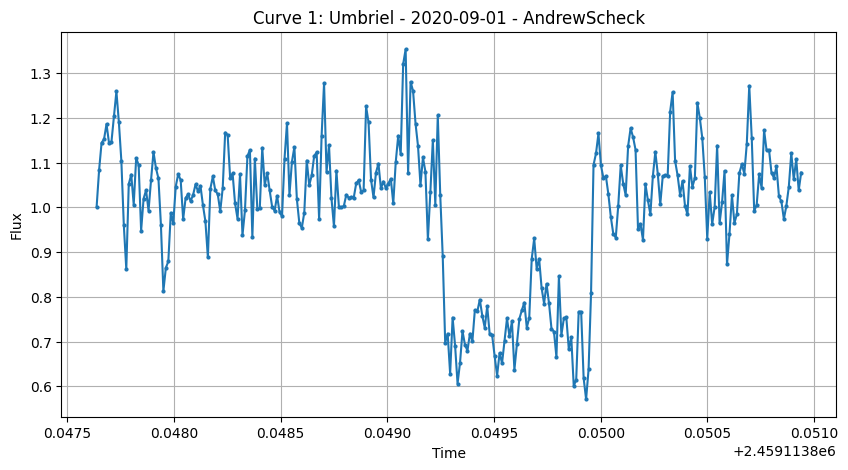

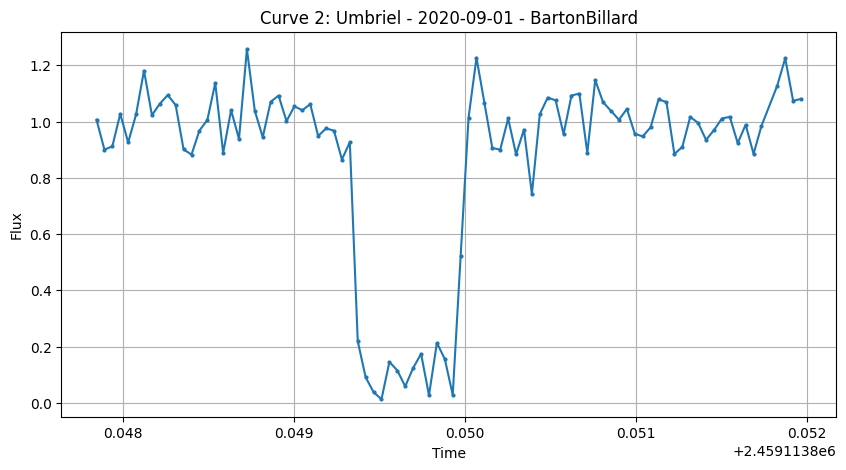

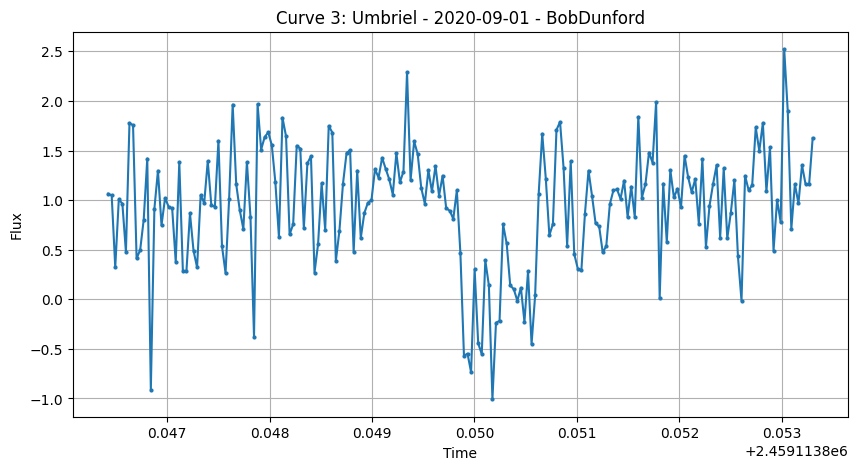

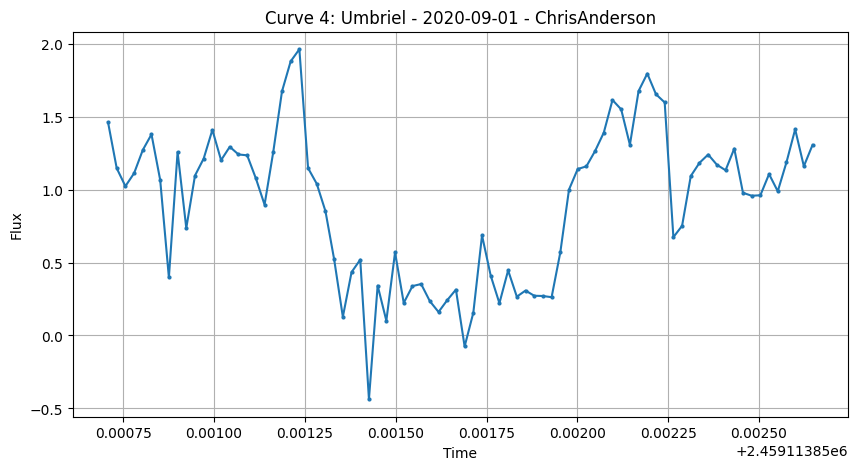

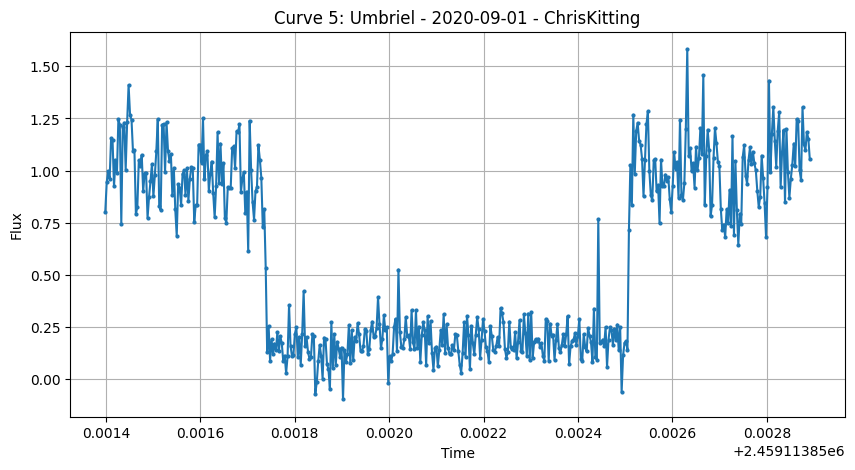

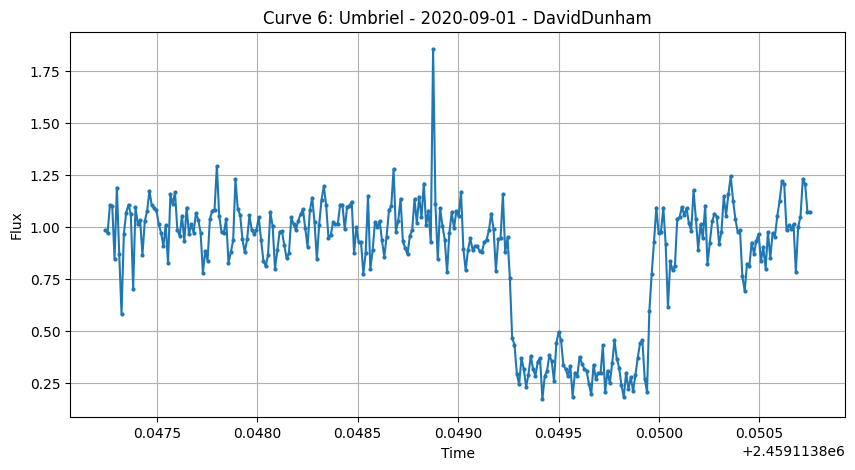

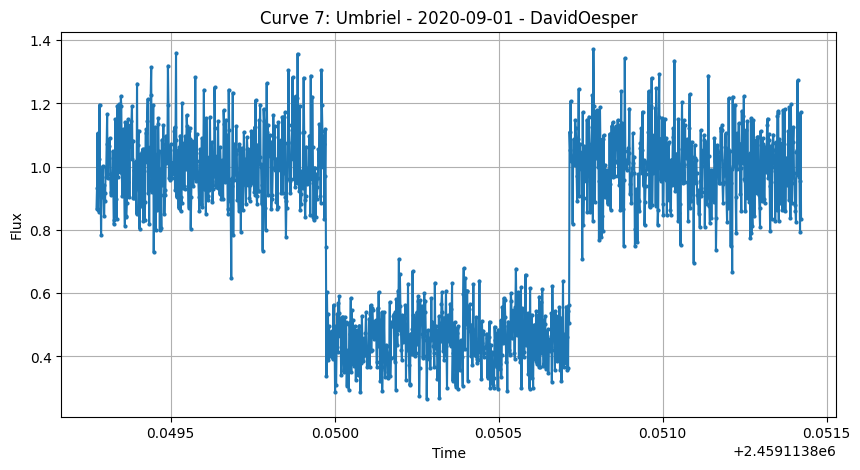

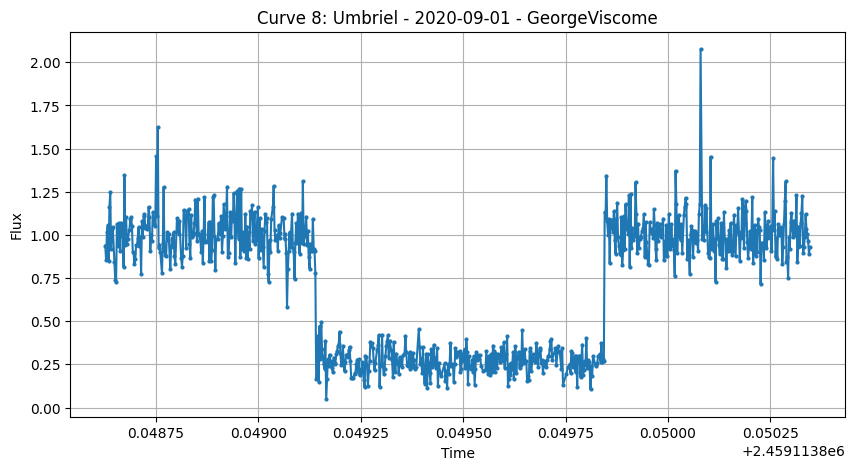

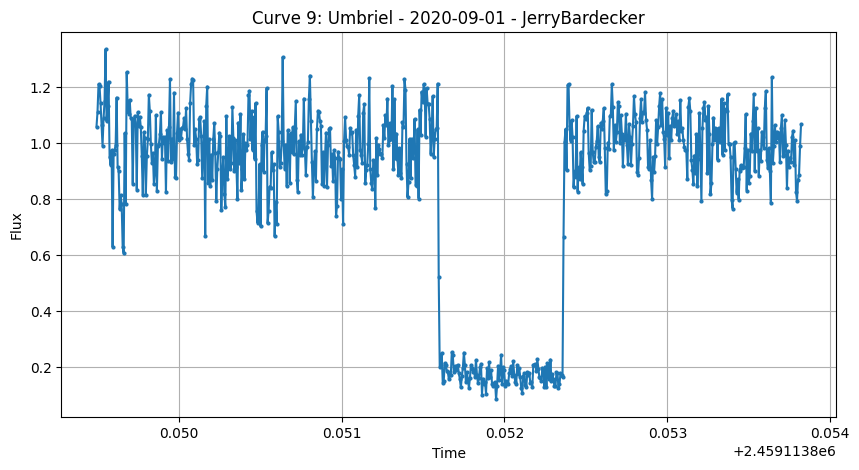

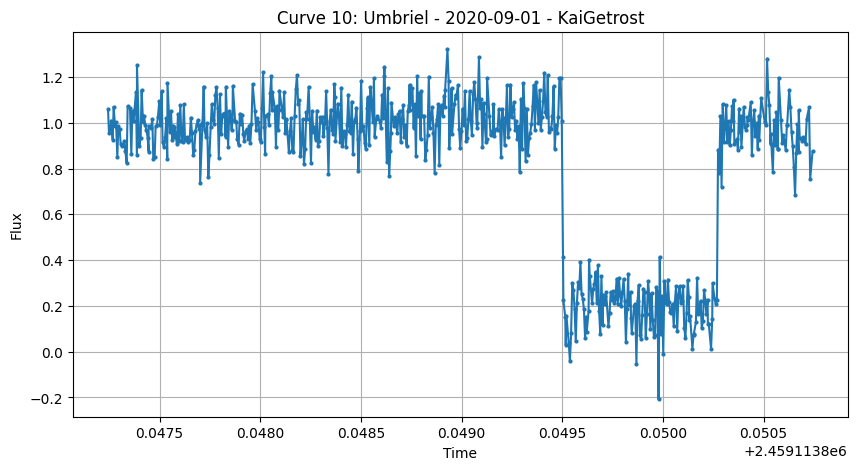

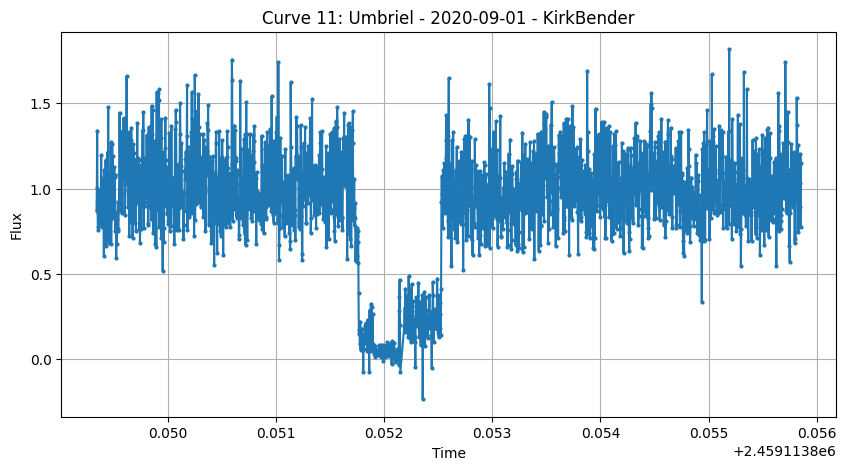

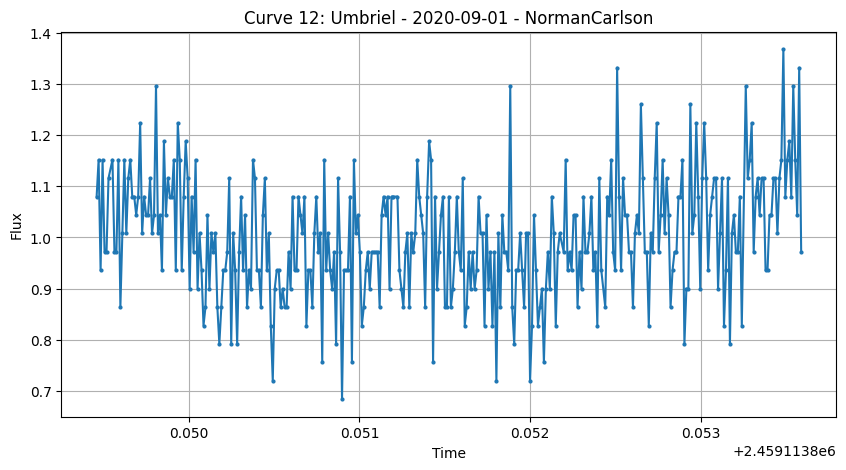

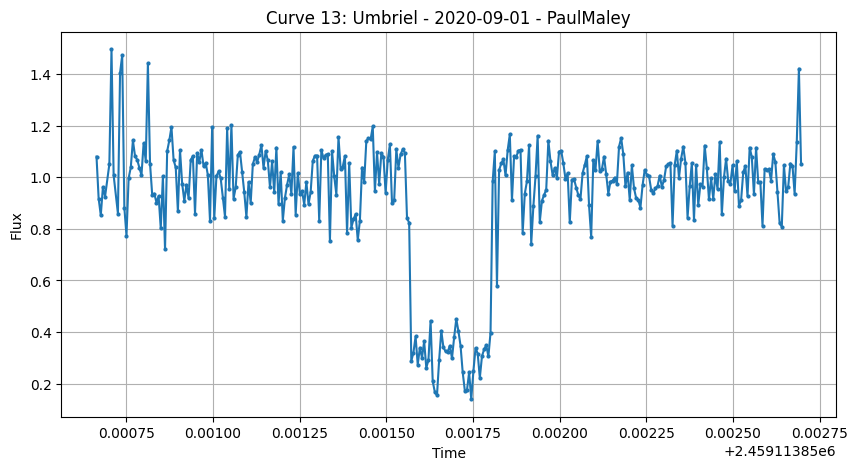

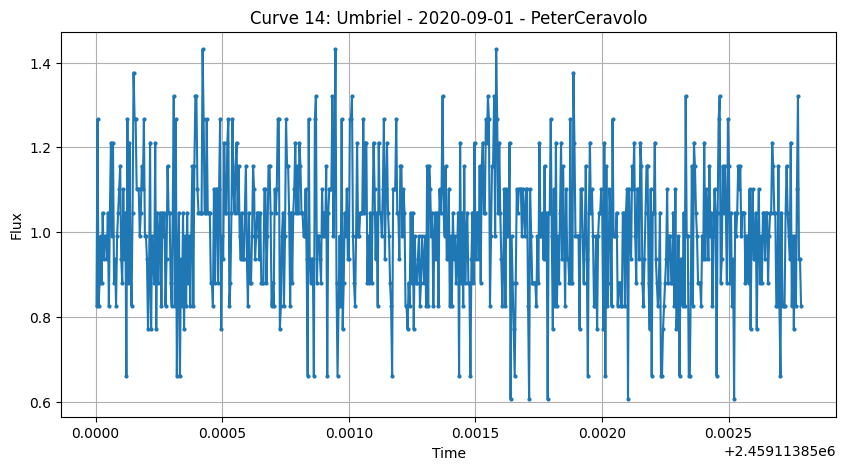

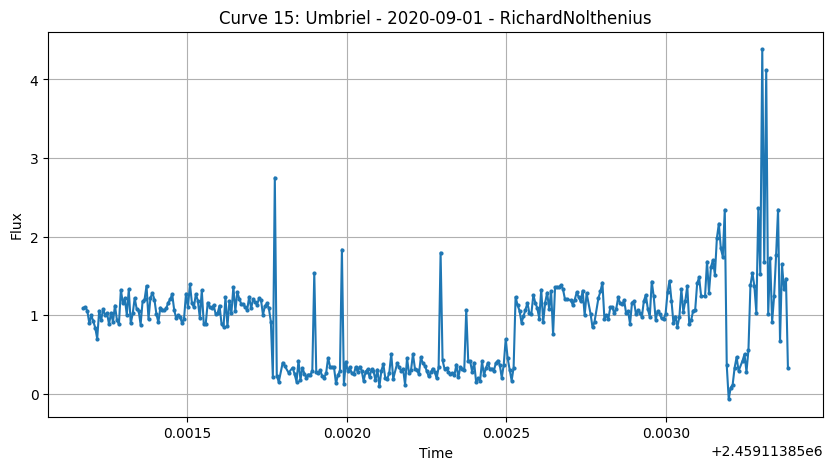

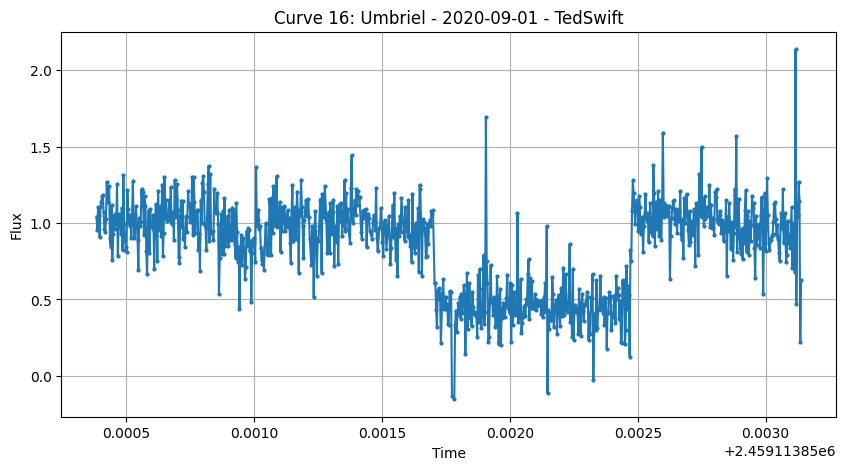

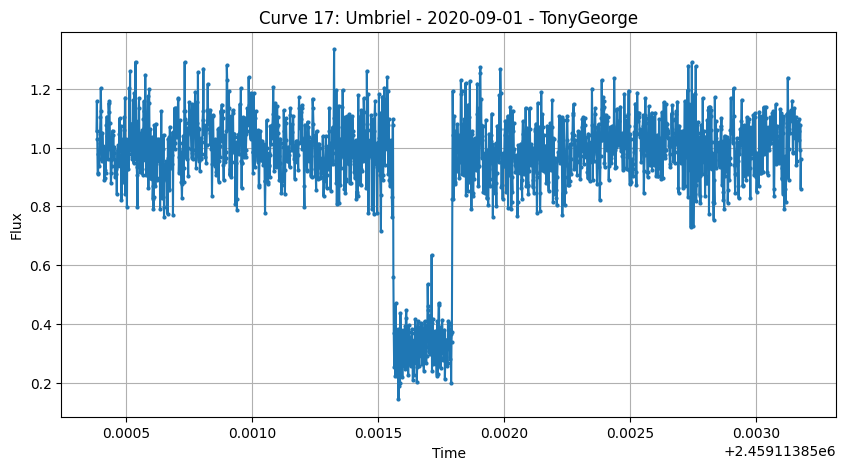

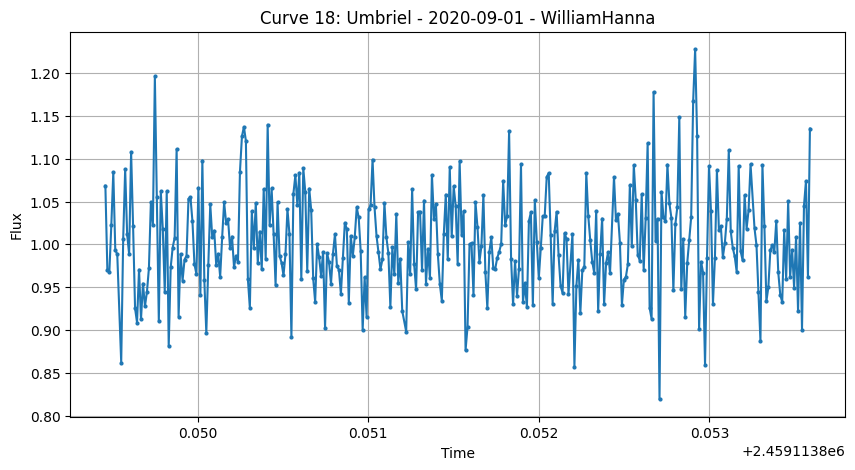

In [54]:
astro_data_access.plot_raw_curves(astro_data_access.get_all_light_curves_from_object(object_name='Umbriel'))

In [81]:
blind_test[blind_test['curve_name'] == 'Umbriel_2020-09-01_NormanCarlson']

,curve_name,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_Flux_std,Feature_Savgol_Max,Feature_Savgol_Min,Feature_Savgol_std,Max_Drawdown,T_12_p,...,KS_13_p,T_14_p,KS_14_p,T_23_p,KS_23_p,T_24_p,KS_24_p,T_34_p,KS_34_p,predict
11,Umbriel_2020-09-01_NormanCarlson,0.660739,1.147599,0.834618,0.112259,1.153019,0.810681,0.069469,-0.472222,0.00142,...,0.013067,0.052289,0.388282,0.938754,0.999028,9.716759e-07,0.000463,9.223012e-07,0.000062,1


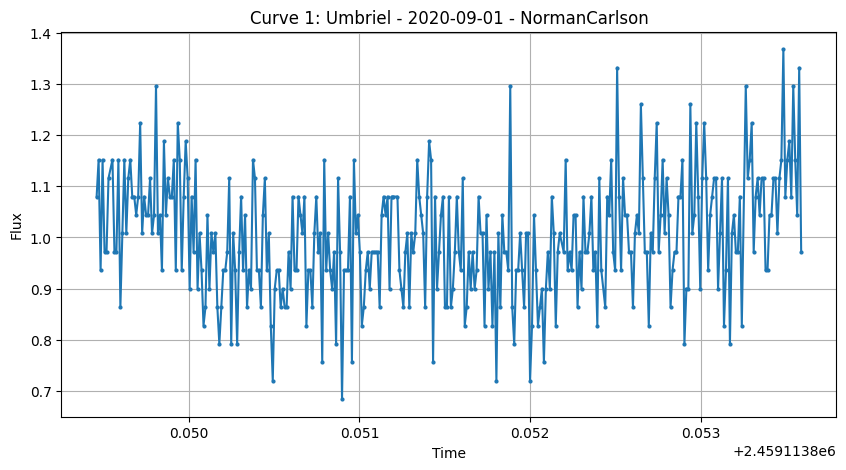

In [82]:
curve = [(astro_data_access.get_single_light_curve(object_name='Umbriel', date='2020-09-01', observer='NormanCarlson'),'Umbriel', '2020-09-01', 'NormanCarlson')]
astro_data_access.plot_raw_curves(curve)

 - Acertou quase todas, menos a curva de Norman Carlson. Por algum motivo o modelo identificou ela erroneamente como curva positiva.